<a href="https://colab.research.google.com/github/khinkhinkhant112316/Corn-Diseases-Classification/blob/main/cornclassgpustop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Identification of corn leaf Diseases Using a deep convolutional neural network architecture by transfer learning


![alt text](https://static.country-guide.ca/wp-content/uploads/2016/04/March-III-2016-Headin_opt.jpeg)


## **Problem Statement**

The plant diseases compose a threat to global food security and smallholder farmers whose livelihoods depend mainly on agriculture and healthy crops. In developing countries, smallholder farmers produce more than 80% of the agricultural production, and reports indicate that more than fifty percent loss in crop due to pests and diseases. The world population expected to grow to more than 9.7 billion by 2050, making food security a major concern in the upcoming years. Hence, rapid and accurate methods of indentying plant diseases are needed to do the appropiate measures.

In this project, we built a Convolutional Neural Network model by transfer learning and fine-tuning to detect diseases in the corn leaves through digital images.




## **Plant Village Dataset**

- The plant-Village dataset contains 39 different classes of plant leaf(healthy and unhealthy) and background images(61,486 in total)(Geetharamani & Pandian,2019). In this project,  we use the version without augmentation and just used the corn dataset, which contained four different classes (Blight, Common rust, Gray Leaf Spot, and Healthy).

In [ ]:
## Import libraries
import warnings
warnings.simplefilter(action='ignore')
import os
import zipfile
from shutil import copyfile
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay


import tensorflow as tf
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Load the Dataset**

- Load and extract the dataset
- Create train and test files
- Split and assign the data into train, validation and test folders(80:10:10)
- Display some images

In [ ]:
## Conection with Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Load and extract the dataset
input_path = "/content/drive/MyDrive/Plant_Village_Dataset_Corn/CORN_L~1.ZIP"

local_zip = input_path
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/drive/MyDrive/Plant_Village_Dataset_Corn')
zip_ref.close()

In [ ]:
extrac_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/'

for set_ in ['Corn_Leaf_Disease']:
    n_blight = len(os.listdir(extrac_path+set_ + '/Blight'))
    n_common_rust = len(os.listdir(extrac_path+set_ + '/Common_Rust'))
    n_gray_leaf_spot = len(os.listdir(extrac_path+set_ + '/Gray_Leaf_Spot'))
    n_health = len(os.listdir(extrac_path+set_ + '/Healthy'))
    print('blight images: {}, common rust images: {}, gray leaf spot images: {}, healt images:{}'.format(n_blight,
                                                                                                         n_common_rust,
                                                                                                         n_gray_leaf_spot,
                                                                                                         n_health))

blight images: 1, common rust images: 1, gray leaf spot images: 1, healt images:1


In [ ]:
import os

try:
    # Creating directories for training data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Healthy')

    # Creating directories for validation data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Healthy')

    # Creating directories for testing data
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Blight')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Common_Rust')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Gray_Leaf_Spot')
    os.mkdir('/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Healthy')
except OSError as e:
    print("Creation of directories failed:", e)


Creation of directories failed: [Errno 17] File exists: '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train'


#### **Split and assign the data into train, validation and test folders(80:10:10)**

In [ ]:
#Split and assign the data into train and test files(80:20)
def split_data(SOURCE, TRAINING, VALIDATION, TESTING):

    all_files = []

    for file_name in os.listdir(SOURCE):
        file_path = SOURCE + file_name

        if os.path.getsize(file_path):
            all_files.append(file_name)
        else:
            print('{} is zero length, so ignoring'.format(file_name))

    n_files = len(all_files)
    split_point_1 = round(n_files * 0.8)
    split_point_2 = round(n_files * 0.9)

    shuffled = random.sample(all_files, n_files)

    train_set = shuffled[:split_point_1]
    val_set = shuffled[split_point_1:split_point_2]
    test_set = shuffled[split_point_2:]

    for file_name in train_set:
        copyfile(SOURCE + file_name, TRAINING + file_name)

    for file_name in val_set:
        copyfile(SOURCE + file_name, VALIDATION + file_name)

    for file_name in test_set:
        copyfile(SOURCE + file_name, TESTING + file_name)

Blight_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Blight/Corn___Northern_Leaf_Blight/'
Common_Rust_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Common_Rust/Corn___Common_rust/'
Gray_Leaf_Spot_SOURCE_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Gray_Leaf_Spot/Corn___Cercospora_leaf_spot Gray_leaf_spot/'
Healthy_SOURCE_DIR = '//content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/Healthy/Corn___healthy/'

TRAINING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Blight/'
TRAINING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Common_Rust/'
TRAINING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Gray_Leaf_Spot/'
TRAINING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/train/Healthy/'

VALIDATION_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Blight/'
VALIDATION_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Common_Rust/'
VALIDATION_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Gray_Leaf_Spot/'
VALIDATION_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/val/Healthy/'

TESTING_Blight_DIR = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Blight/'
TESTING_Common_Rust_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Common_Rust/'
TESTING_Gray_Leaf_Spot_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Gray_Leaf_Spot/'
TESTING_Healthy_DIR ='/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test/Healthy/'


split_data(Blight_SOURCE_DIR, TRAINING_Blight_DIR, VALIDATION_Blight_DIR, TESTING_Blight_DIR)
split_data(Common_Rust_SOURCE_DIR, TRAINING_Common_Rust_DIR, VALIDATION_Common_Rust_DIR, TESTING_Common_Rust_DIR)
split_data(Gray_Leaf_Spot_SOURCE_DIR,TRAINING_Gray_Leaf_Spot_DIR, VALIDATION_Gray_Leaf_Spot_DIR, TESTING_Gray_Leaf_Spot_DIR)
split_data(Healthy_SOURCE_DIR,TRAINING_Healthy_DIR, VALIDATION_Healthy_DIR, TESTING_Healthy_DIR)

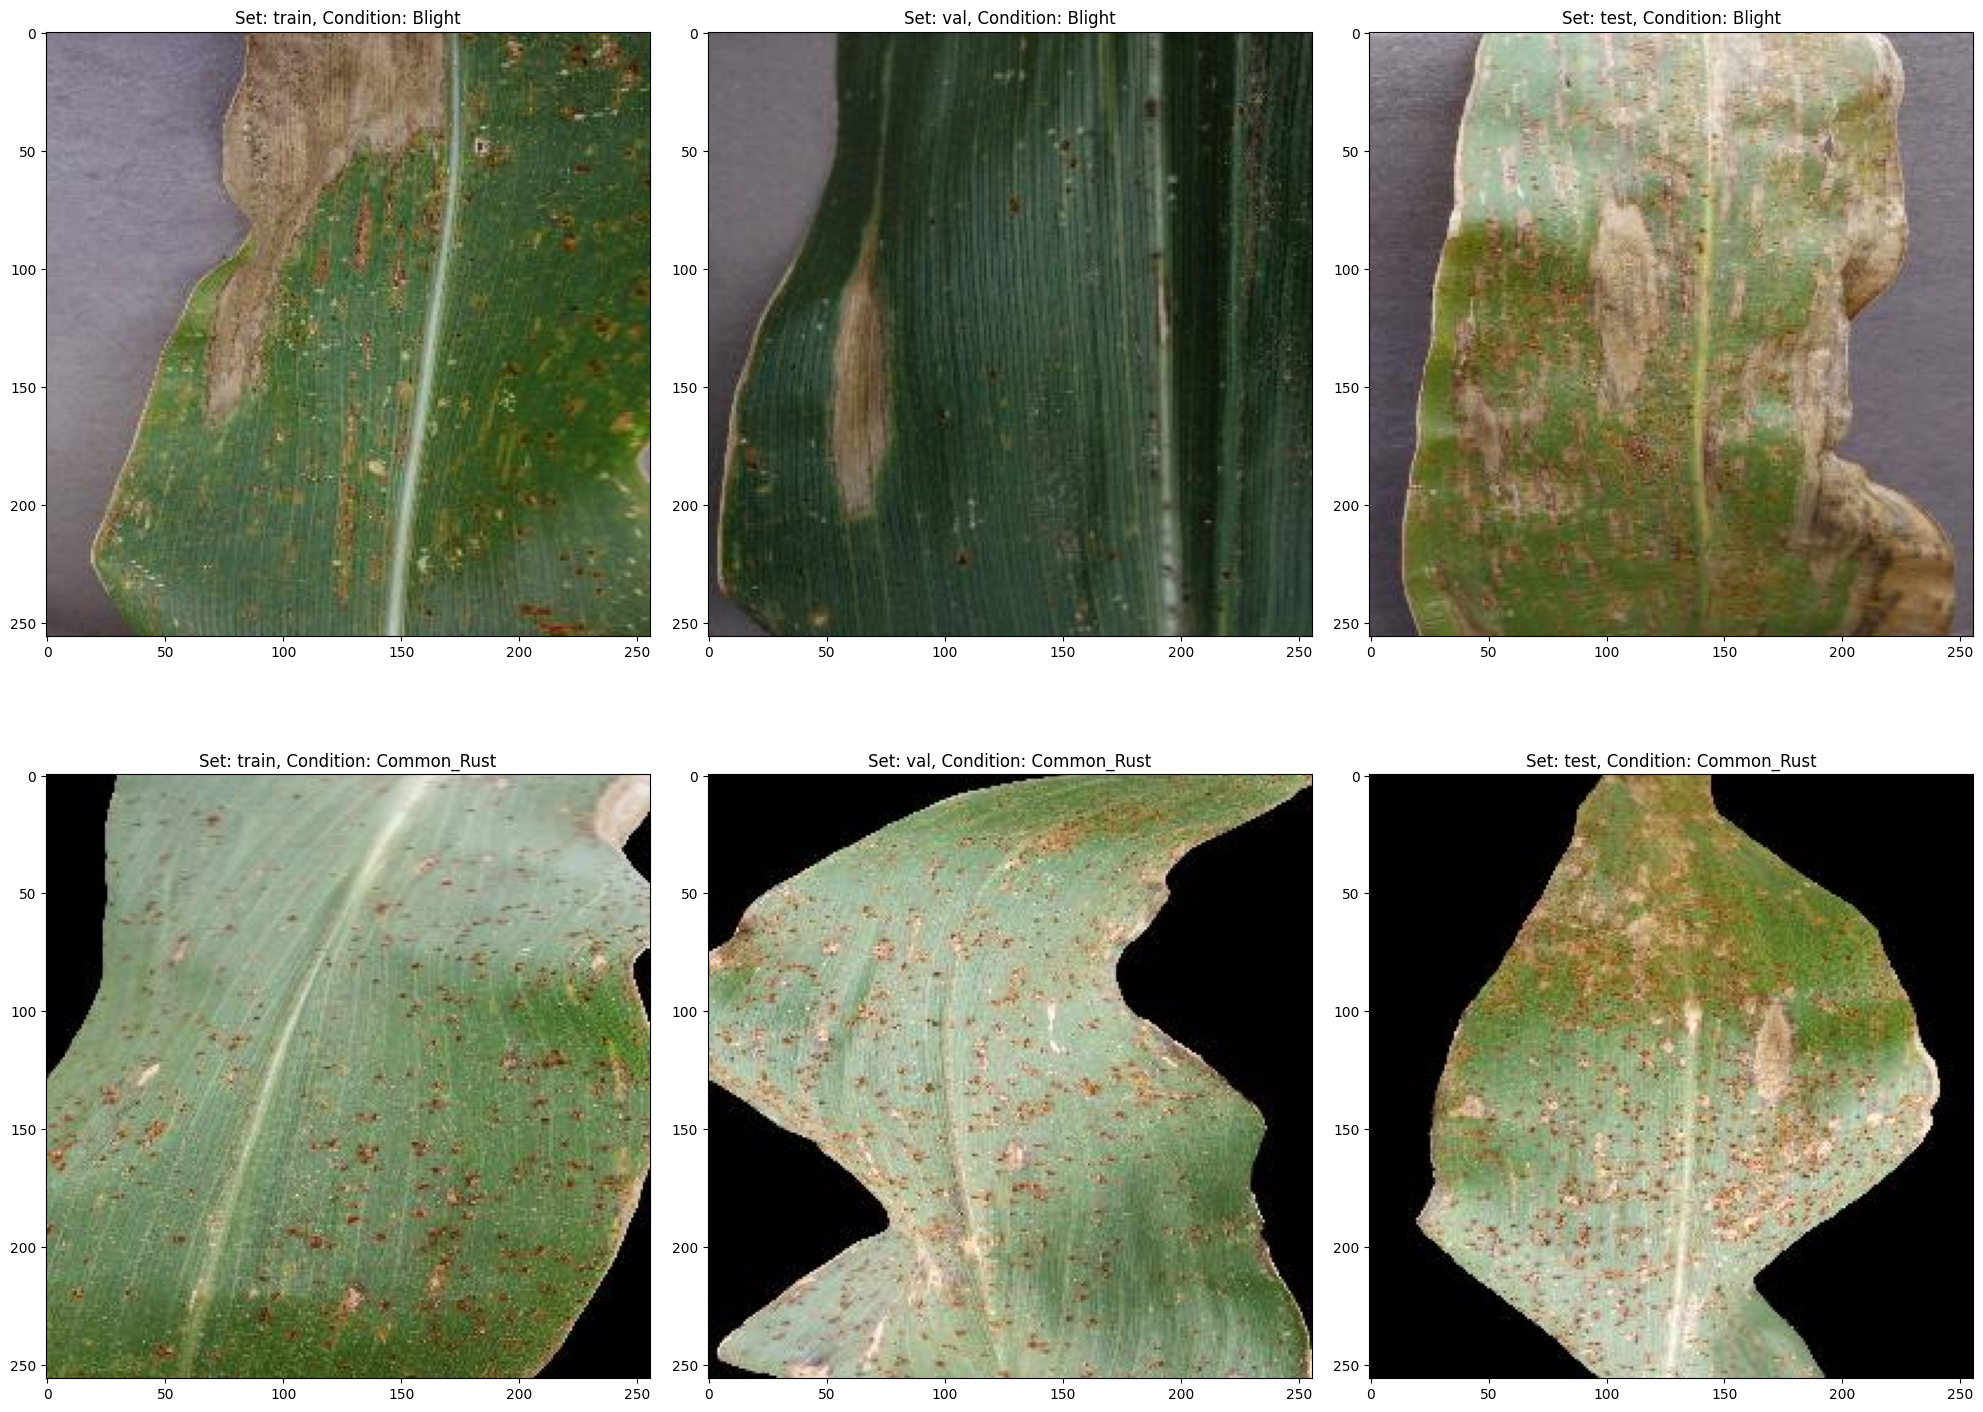

In [8]:
##
path_ = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/'

fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val', 'test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Blight/'+os.listdir(set_path+'/Blight')[0]))
    ax[i].set_title('Set: {}, Condition: Blight'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Common_Rust/'+os.listdir(set_path+'/Common_Rust')[0]))
    ax[i+3].set_title('Set: {}, Condition: Common_Rust'.format(set_))

#### **Diplay some images**

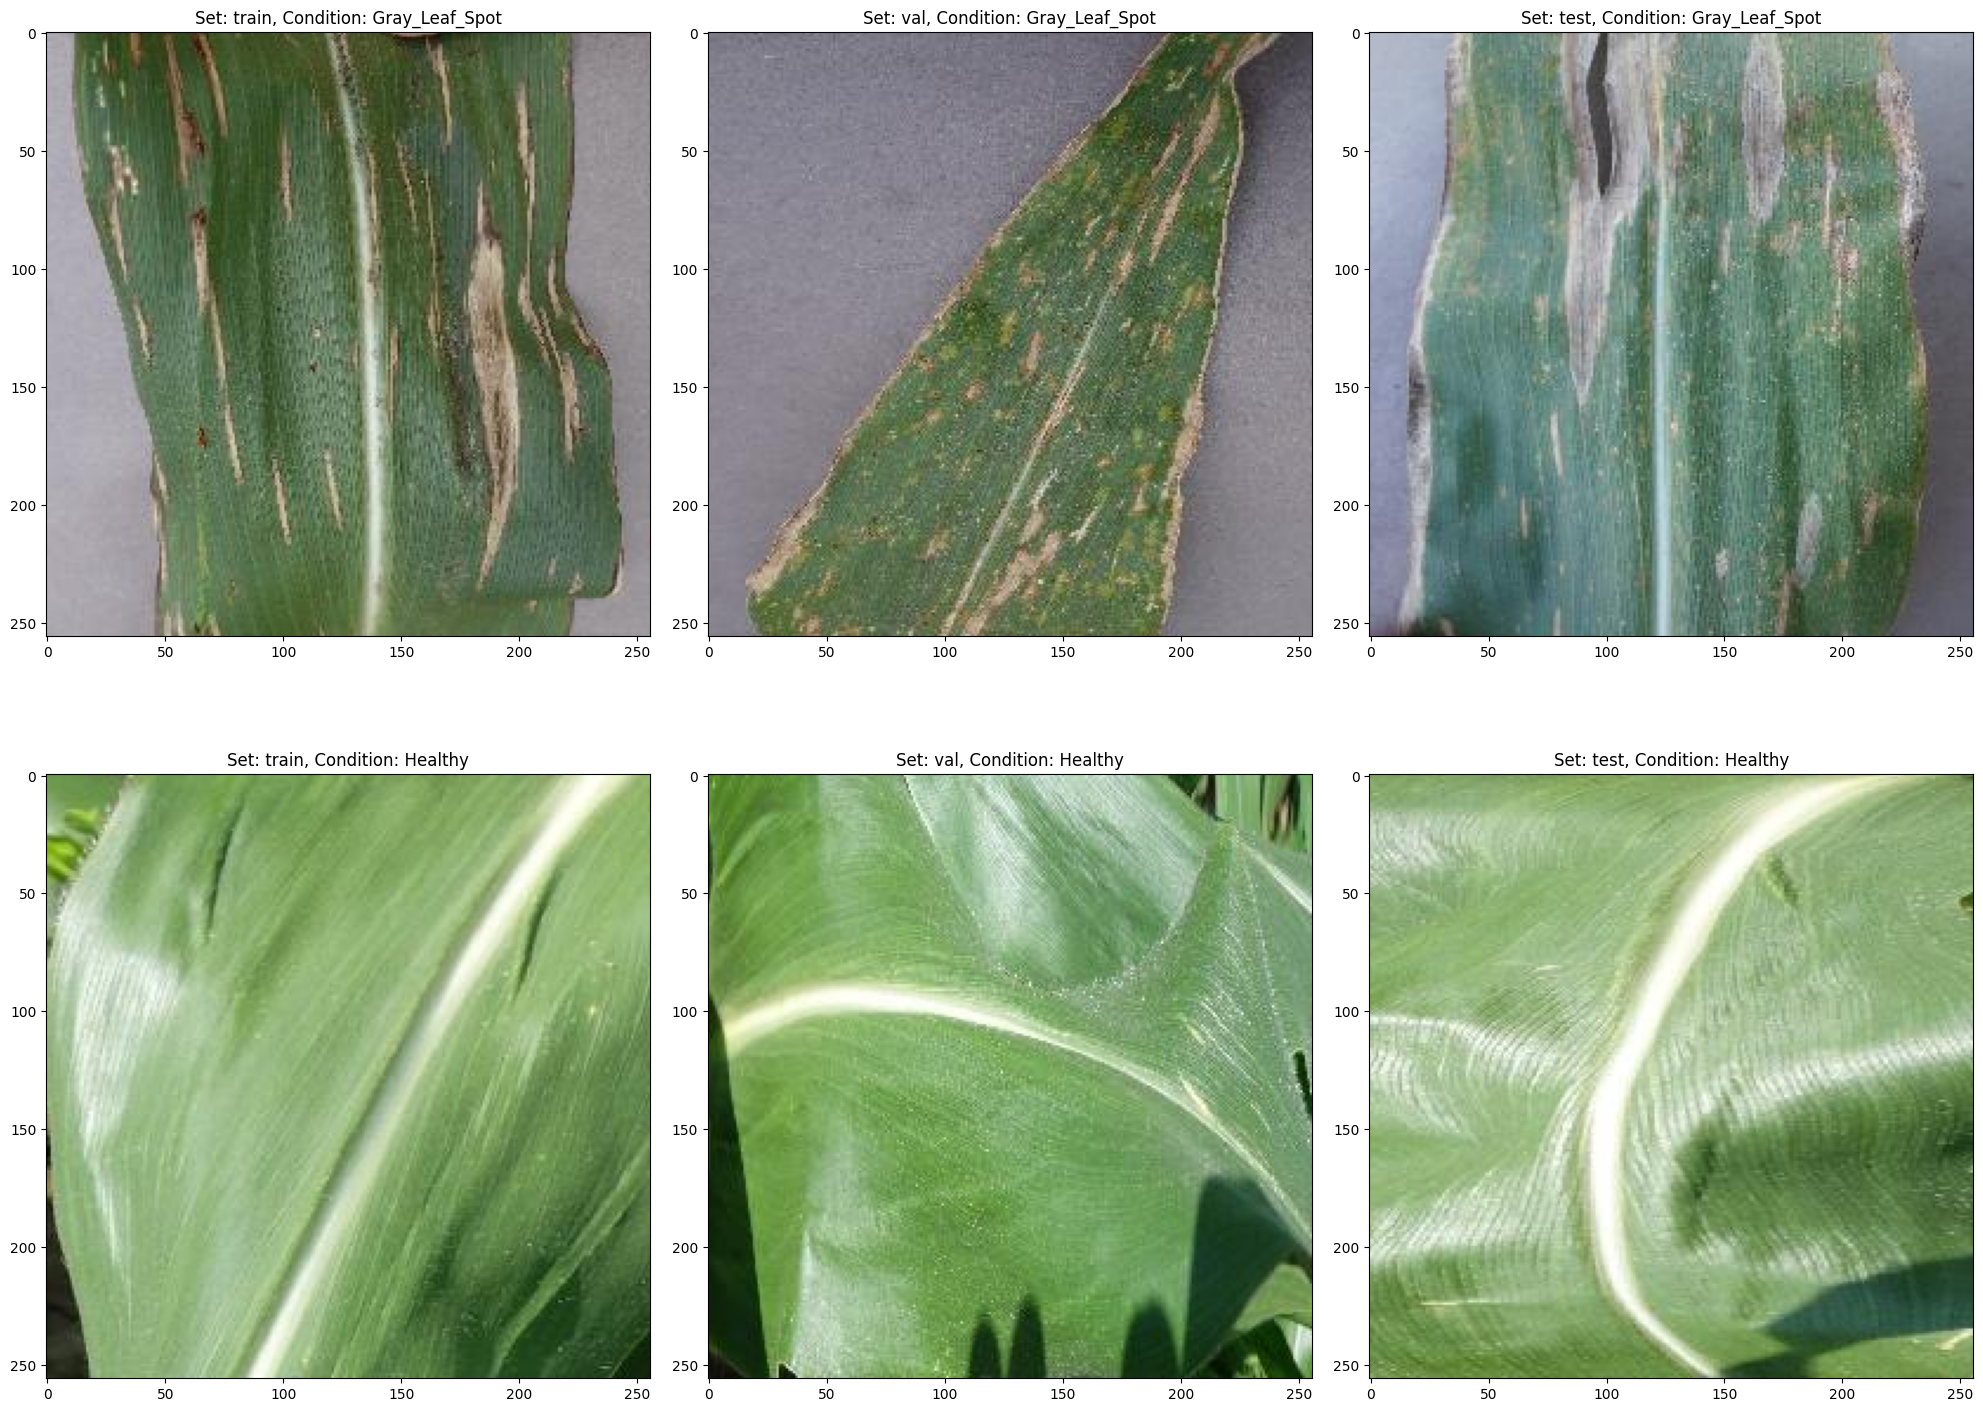

In [9]:
fig, ax = plt.subplots(2,3,figsize=(20,15))
ax = ax.ravel()
plt.tight_layout()

for i, set_ in enumerate(['train','val','test']):
    set_path = path_+ set_
    ax[i].imshow(plt.imread(set_path+'/Gray_Leaf_Spot/'+os.listdir(set_path+'/Gray_Leaf_Spot')[0]))
    ax[i].set_title('Set: {}, Condition: Gray_Leaf_Spot'.format(set_))
    ax[i+3].imshow(plt.imread(set_path+'/Healthy/'+os.listdir(set_path+'/Healthy')[0]))
    ax[i+3].set_title('Set: {}, Condition: Healthy'.format(set_))

## **Data preprocessing**

- Split data into train and test set
- Data normalization[0,1]
- Data augmentation using saveral techniques such as:
  - image flipping
  - zoom
  - shear
  - width and height shift
  - image rotation
  - Image brightness range
  - Featurewise center
  - Featurewise std normalization
  
Note: the techniques of data augmentation were implemented using ImageDataGenerator from Keras.

In [10]:
def train_val_test_data(img_dims, batch_size):

  ## Training data
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                       rotation_range = 40,
                                       width_shift_range = .2,
                                       height_shift_range = .2,
                                       shear_range = .2,
                                       zoom_range = 0.3,
                                       horizontal_flip = True,
                                       vertical_flip=True,
                                       brightness_range=[0.5, 1.5],
                                       featurewise_center=True,
                                       featurewise_std_normalization=True,
                                       fill_mode = 'nearest',
                                   )


  ## Train generator
  train_gen = train_datagen.flow_from_directory(directory = path_ + 'train',
                                                  target_size = (img_dims, img_dims),
                                                  batch_size = batch_size,
                                                  class_mode = 'categorical',
                                                  shuffle = True)
  ## Validation Data

  validation_datagen = ImageDataGenerator(rescale = 1./255)
  ## validation generator

  val_gen = validation_datagen.flow_from_directory(directory = path_ + 'val',
                                                      target_size = (img_dims, img_dims),
                                                      batch_size = batch_size,
                                                      class_mode = 'categorical',
                                                      shuffle = True)



  return train_gen, val_gen

In [11]:
img_dims = 224
batch_size = 128

train_gen, val_gen = train_val_test_data(img_dims, batch_size)

Found 3852 images belonging to 4 classes.
Found 2221 images belonging to 4 classes.


## **Modeling**

- Transfer learning (MobileNetV2 architecture)
- Fine-tuning


### **Transfer learning**
- Import MobileNetV2 model pretrained with imaginet dataset
- Freezing all layers from MobileNetV2 model
- Built a model with new top layers to classify 4 classes instead of 1000
- Training:
  - Epochs = 50
  - Adam optimizer with a 0.0001 base learning rate
- Model performance

In [12]:
import tensorflow as tf

# Check if GPUs are available
devices = tf.config.list_physical_devices('GPU')
if devices:
    print(devices[0])
    name_gpu = devices[0].name
    # Define strategy only if GPU is available
    strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)
    print("Strategy defined with GPU:", name_gpu)
else:
    print("No GPU available. Using CPU.")
    # Define CPU strategy if no GPU is available
    strategy = tf.distribute.OneDeviceStrategy(device="CPU")


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


ValueError: Unknown attribute 'physical_device' is encountered while parsing the device spec: '/physical_device:GPU:0'.

In [13]:
## Choose a device type (CPU or GPU)
devices = tf.config.list_physical_devices('GPU')
print(devices[0])

## Name divice
name_gpu = "GPU:0"

## Define my strategy like One Device Strategy
strategy = tf.distribute.OneDeviceStrategy(device=name_gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


#### **CNN-MobileNetV2 model**

- MobileNetV2 is a convolutional neural network architecture that seeks to perform well on mobile devices. It is based on an inverted residual structure where the residual connections are between the bottleneck layers. The intermediate expansion layer uses lightweight depthwise convolutions to filter features as a source of non-linearity. As a whole, the architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers.

![MobilenetV2 Model](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-06_at_10.37.14_PM.png)

MobileNet architecture

In [14]:
def mobilenetv2():

  mobilenet_m = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(img_dims,img_dims,3),
                                                               include_top = False,
                                                               weights = 'imagenet'
                                                               )
  x = mobilenet_m.trainable = False
  x = mobilenet_m.output

  x = GlobalAveragePooling2D()(x)
  out = Dense(4,activation='softmax')(x)

  model = Model(inputs = mobilenet_m.inputs, outputs = out)

  model.summary()

  return model

In [15]:
with strategy.scope():

  mobilenetv2_model = mobilenetv2()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = .0001),metrics = ['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

### **Train the MobileNetV2 model**

In [18]:
epochs_1 = 50
history_1 = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                               epochs=epochs_1, validation_data=(val_gen),
                               validation_steps=val_gen.samples // batch_size
                                    )

Epoch 1/50
30/30 [==============================] - 88s 3s/step - loss: 0.1584 - accuracy: 0.9423 - val_loss: 0.1452 - val_accuracy: 0.9467
Epoch 2/50
30/30 [==============================] - 81s 3s/step - loss: 0.1691 - accuracy: 0.9283 - val_loss: 0.1436 - val_accuracy: 0.9467
Epoch 3/50
30/30 [==============================] - 82s 3s/step - loss: 0.1590 - accuracy: 0.9393 - val_loss: 0.1645 - val_accuracy: 0.9357
Epoch 4/50
30/30 [==============================] - 82s 3s/step - loss: 0.1572 - accuracy: 0.9337 - val_loss: 0.1509 - val_accuracy: 0.9384
Epoch 5/50
30/30 [==============================] - 81s 3s/step - loss: 0.1484 - accuracy: 0.9428 - val_loss: 0.1504 - val_accuracy: 0.9375
Epoch 6/50
30/30 [==============================] - 80s 3s/step - loss: 0.1454 - accuracy: 0.9436 - val_loss: 0.1480 - val_accuracy: 0.9389
Epoch 7/50
30/30 [==============================] - 82s 3s/step - loss: 0.1555 - accuracy: 0.9385 - val_loss: 0.1299 - val_accuracy: 0.9504
Epoch 8/50
30/30 [==

#### **MobileNetV2 model performance**
- loss and accuracy plot
- Evaluation with the validation set
- Evaluation metrics:
 - Accuracy


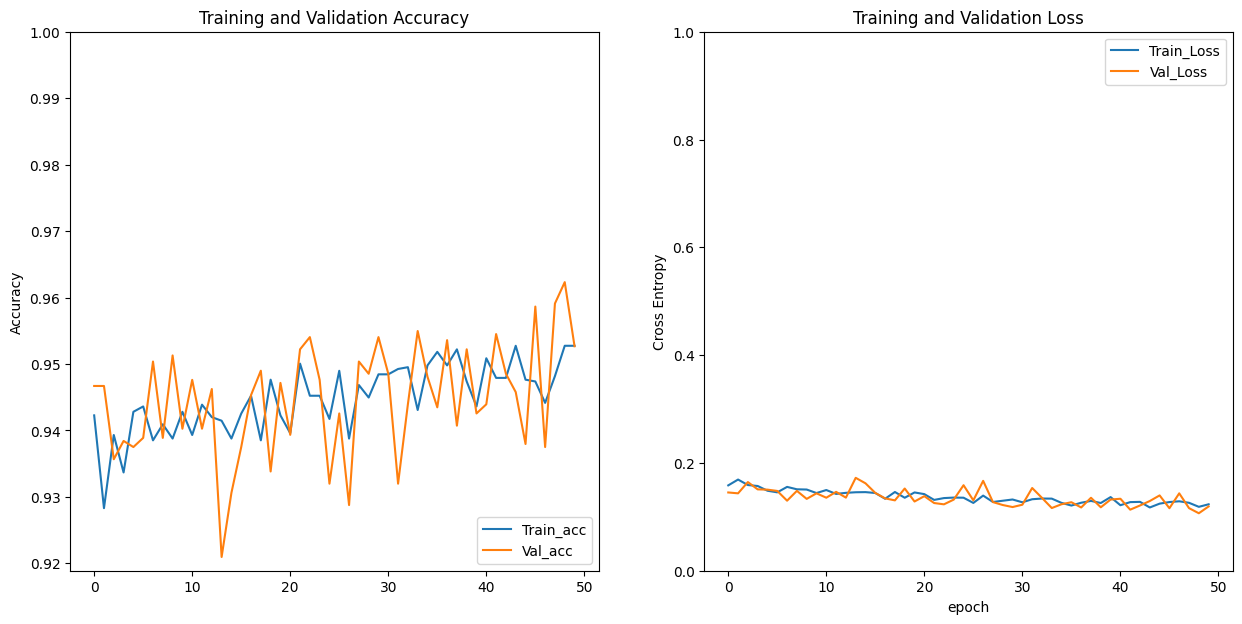

In [19]:
### Loss and accuracy plot
acc_mob = history_1.history['accuracy']
val_acc_mob = history_1.history['val_accuracy']

loss_mob = history_1.history['loss']
val_loss_mob = history_1.history['val_loss']

plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_Loss')
plt.plot(val_loss_mob, label='Val_Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
result_eval = mobilenetv2_model.evaluate(val_gen, verbose =0)

for metric, eval in zip(mobilenetv2_model.metrics_names, result_eval):
  print(metric + ': {:.3}'.format(eval))

loss: 0.119
accuracy: 0.953


### **Fine-tuning the model**
- Un-freeze the top layers of MobileNetV2 model
- training:
  - Total epochs = 75
  - Adam optimazer with a low learning rate (base_learning_rate/10) to avoid the overfitting

In [21]:
## Unfreezing layers
mobilenetv2_model.trainable = True

In [22]:
## Fine-tuning
## number of layer in the pre-trained model
print('Number of layer in the pre-trained model:{}'.format(len(mobilenetv2_model.layers)))
fine_tune_at = 100

for layer in mobilenetv2_model.layers[:fine_tune_at]:
  layer.trainable = False
print(f"Trainable Layers: {len(mobilenetv2_model.trainable_variables)}")

Number of layer in the pre-trained model:156
Trainable Layers: 56


In [23]:
with strategy.scope():

  mobilenetv2_model.summary()
  mobilenetv2_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr = 0.0001/10),metrics = ['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
## Training
fine_tune_epochs = 25
total_epochs = epochs_1 + fine_tune_epochs

history_fine = mobilenetv2_model.fit(train_gen, steps_per_epoch=train_gen.samples // batch_size,
                                            epochs=total_epochs,
                                            initial_epoch = history_1.epoch[-1],
                                            validation_data=(val_gen),
                                            validation_steps=val_gen.samples // batch_size,
                                    )

Epoch 50/75
30/30 [==============================] - 95s 3s/step - loss: 0.2734 - accuracy: 0.9133 - val_loss: 5.2501 - val_accuracy: 0.6457
Epoch 51/75
30/30 [==============================] - 81s 3s/step - loss: 0.1205 - accuracy: 0.9519 - val_loss: 2.4727 - val_accuracy: 0.8658
Epoch 52/75
30/30 [==============================] - 83s 3s/step - loss: 0.1309 - accuracy: 0.9527 - val_loss: 1.5143 - val_accuracy: 0.8676
Epoch 53/75
30/30 [==============================] - 82s 3s/step - loss: 0.0990 - accuracy: 0.9633 - val_loss: 1.9408 - val_accuracy: 0.8024
Epoch 54/75
30/30 [==============================] - 83s 3s/step - loss: 0.1055 - accuracy: 0.9589 - val_loss: 1.3976 - val_accuracy: 0.8557
Epoch 55/75
30/30 [==============================] - 81s 3s/step - loss: 0.0801 - accuracy: 0.9721 - val_loss: 3.5867 - val_accuracy: 0.7486
Epoch 56/75
30/30 [==============================] - 81s 3s/step - loss: 0.0989 - accuracy: 0.9667 - val_loss: 9.8544 - val_accuracy: 0.6659
Epoch 57/75
3

#### **Fine-tuning model performance**
- loss and accuracy plot
- Evaluate with the validation set
- Metrics:
 - Accuracy


In [ ]:
acc_mob += history_fine.history['accuracy']
val_acc_mob += history_fine.history['val_accuracy']

loss_mob += history_fine.history['loss']
val_loss_mob += history_fine.history['val_loss']


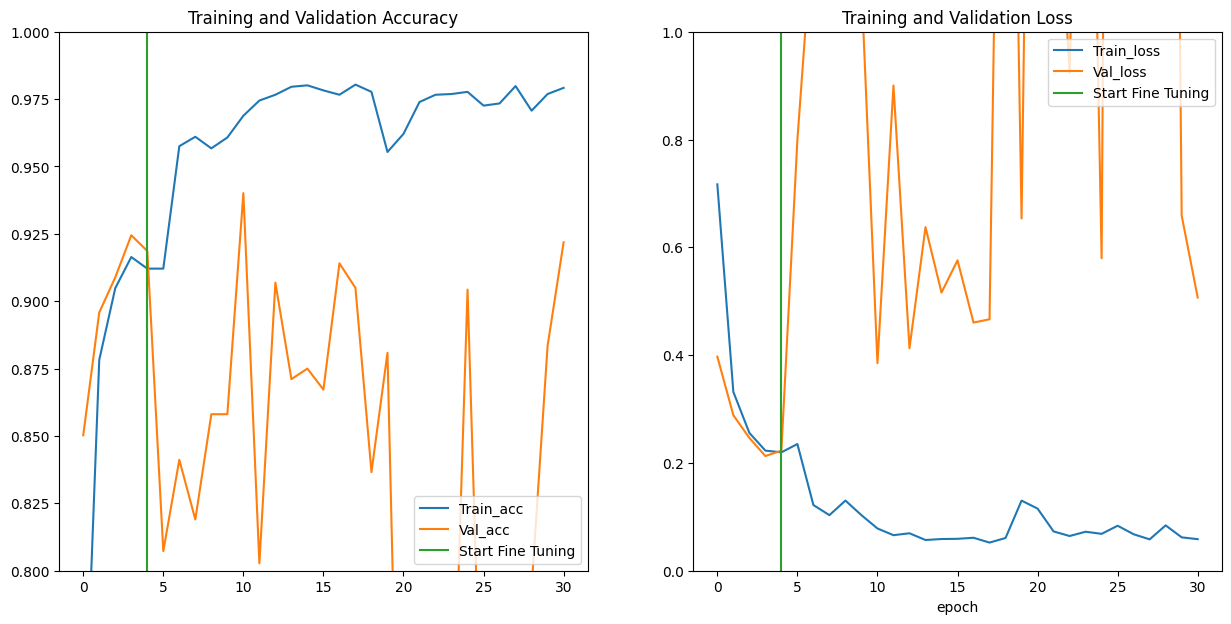

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(acc_mob, label='Train_acc')
plt.plot(val_acc_mob, label='Val_acc')
plt.ylim([0.8, 1])
plt.plot([epochs_1-1,epochs_1-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss_mob, label='Train_loss')
plt.plot(val_loss_mob, label='Val_loss')
plt.ylim([0, 1.0])
plt.plot([epochs_1-1,epochs_1-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
result_eval_f = mobilenetv2_model.evaluate(val_gen, verbose =0)

for metric_, eval_ in zip(mobilenetv2_model.metrics_names, result_eval_f):
  print(metric_ + ': {:.3}'.format(eval_))

loss: 0.509
accuracy: 0.921


##### **Observations**

- The initial model with the transfer learning technique reaches a good performance(accuracy = 0.87).

- Unfreezing some layers (fine-tuning) give more performance to the model, reaching an accuracy = 0.92 and loss = 0.21 with the validation set

### **Model Evaluation with the test set**

In [ ]:
## Import the test set
input_test = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test'
labels = os.listdir(input_test)
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
import numpy as np

def get_data(input_test, img_dims):
  """
  This function handles data in a robust way, ensuring consistency in shape.

  Args:
      data: A list or numpy array of data.
      img_dims: The desired image dimensions (for elements beyond 2D).

  Returns:
      A numpy array of the data, reshaped to img_dims if necessary.
  """
  if not isinstance(data, np.ndarray):
    data = np.array(data)

  # Ensure consistent shape after 2nd dimension (modify as needed)
  data = ensure_consistent_shape(data, img_dims)

  if len(data.shape) == 1:
    data = data.reshape(-1, img_dims[1])  # Reshape to 2D if 1D
  return data


In [ ]:
import cv2
import os
import numpy as np
input_test = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/Corn_Leaf_Disease/test'
labels = os.listdir(input_test)

def get_data(data_dir, img_dims):
    data = []
    labels = os.listdir(data_dir)
    for label in labels:
        label_dir = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(label_dir):
            try:
                img_path = os.path.join(label_dir, img_name)
                img_arr = cv2.imread(img_path)
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)  # convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_dims, img_dims))  # Resize images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")
    return np.array(data, dtype=object)



In [ ]:
test_set_ = get_data(input_test,img_dims)

## X and y test
X_test, y_test = [],[]
for feature, labels in test_set_:
  X_test.append(feature)
  y_test.append(labels)
## Convert the data in arrays
X_test = np.array(X_test) / 255
y_test = np.array(y_test)

In [ ]:
## Prediction
y_pred = np.argmax(mobilenetv2_model.predict(X_test), axis = -1)

67/67 [==============================] - 6s 46ms/step


Accuracy: 0.931%


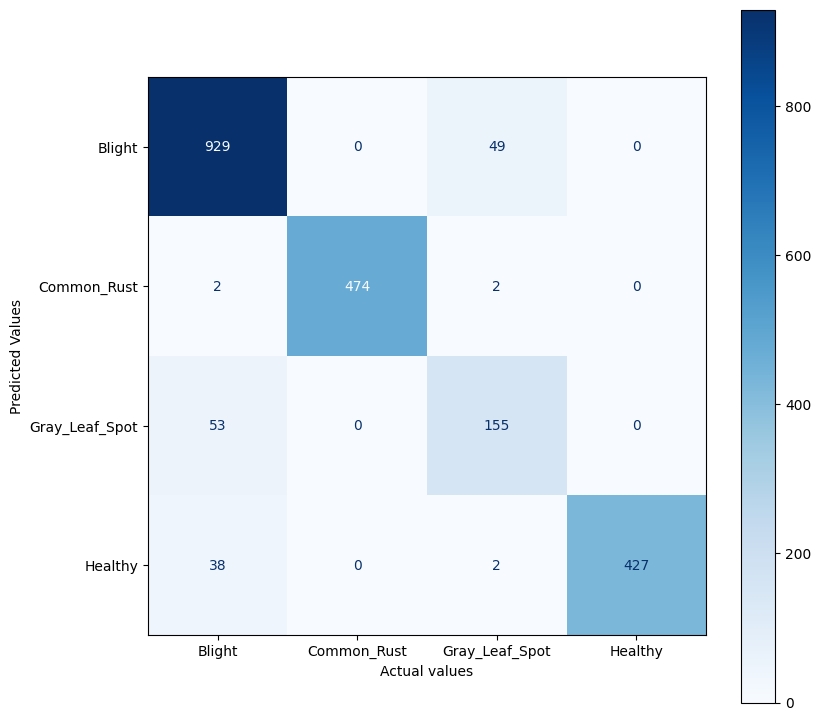

In [ ]:
from sklearn.metrics import accuracy_score

#print("CONFUSION MATRIX ------------------------------")
fig, ax = plt.subplots(figsize=(9,9))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap = 'Blues', ax = ax)
ax.set_xlabel("Actual values")
ax.set_ylabel("Predicted Values")
ax.xaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])
ax.yaxis.set_ticklabels(["Blight", "Common_Rust","Gray_Leaf_Spot", "Healthy"])

## Accuracy and F1-Score
acc_x = accuracy_score(y_test, y_pred)

print(f'Accuracy: {round(acc_x, 3)}%')

In [ ]:
## Save model in HDF5 format
export_path = '/content/drive/MyDrive/Plant_Village_Dataset_Corn/save_model/model_mobnetv2'
mobilenetv2_model.save(export_path)#export_path